In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import LayoutLMTrainer

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "layoutlm"
dataset_name = "cord"

In [5]:
logging.basicConfig(filename='logs/layoutlm_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("katanaml/cord")

Repo card metadata block was not found. Setting CardData to empty.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
})

In [8]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'I-menu.cnt',
 'I-menu.discountprice',
 'I-menu.nm',
 'I-menu.num',
 'I-menu.price',
 'I-menu.sub_cnt',
 'I-menu.sub_nm',
 'I-menu.sub_price',
 'I-menu.unitprice',
 'I-sub_total.discount_price',
 'I-sub_total.etc',
 'I-sub_total.service_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-total.cashprice',
 'I-total.changeprice',
 'I-total.creditcardprice',
 'I-total.emoneyprice',
 'I-total.menuqty_cnt',
 'I-total.menutype_cnt',
 'I-total.total_etc',
 'I-total.total_price']

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

23

In [10]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

In [11]:
train_dataset = ImageLayoutDataset(dataset['train'], llm_tokenizer)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:01<00:00, 510.40it/s]


In [12]:
validation_dataset = ImageLayoutDataset(dataset['validation'], llm_tokenizer)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 555.47it/s]


In [13]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle = False
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

## Importing model

In [14]:
device = "cuda"

In [15]:
layoutlm = LayoutLMForTokenClassification.from_pretrained('microsoft/layoutlm-base-uncased', num_labels = n_classes)
layoutlm.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

In [16]:
print(f'''
    Model Info
    -----------------
    
    Treinable params: {sum(p.numel() for p in layoutlm.parameters() if p.requires_grad)}
    Non Treinable params: {sum(p.numel() for p in layoutlm.parameters() if not p.requires_grad)}

''')


    Model Info
    -----------------
    
    Treinable params: 112645655
    Non Treinable params: 0




In [17]:
trainer = LayoutLMTrainer(
    layoutlm,
)

In [18]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:16<00:00, 25.68s/it]


In [25]:
best_idx = None
for idx, f1 in enumerate(trainer.history['validation-f1']):
    if f1 == trainer.best_f1:
        best_idx = idx 

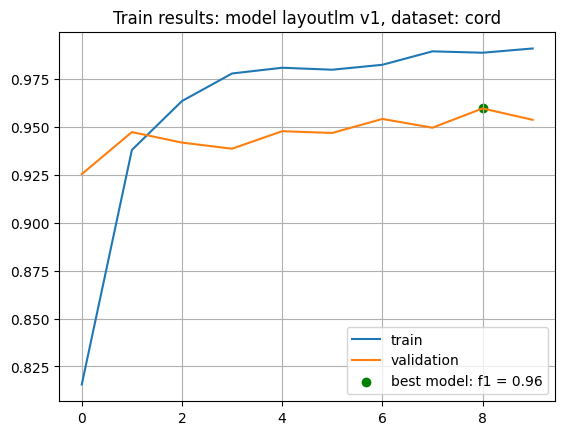

In [27]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.title(f"Train results: model {trainer.model_name}, dataset: {dataset_name}")
plt.scatter(
    best_idx,
    trainer.best_f1.item(), 
    color = "green",
    label = f"best model: f1 = {round(trainer.best_f1.item(), 2)}"
)
plt.grid()
plt.legend()

In [21]:
trainer.history['validation-f1']

[0.9254345893859863,
 0.9473925232887268,
 0.9419029355049133,
 0.938700795173645,
 0.9478499293327332,
 0.9469350576400757,
 0.9542543292045593,
 0.9496797919273376,
 0.959743857383728,
 0.9537968635559082]

In [22]:
trainer.history['train-f1']

[0.8155394792556763,
 0.9380485415458679,
 0.9636034965515137,
 0.9780072569847107,
 0.9810015559196472,
 0.9799690246582031,
 0.982550323009491,
 0.9895715117454529,
 0.9888487458229065,
 0.9910686612129211]